***In this project, forecasting will be processed with considering 'promotion' featureas well.<br>
Also, we will implement forecasting per each product family***

## Blue print

1. Investigate the dataset. (unique values, data type etc)
2. How to numerize *family* features?
3. How to convert *date* to time features?
4. Split *train* dataset to *ourtrain* and *ourtest* for pre-validation.
5. Apply various ML models. (Trend, Periodtogram, Cycles, Hybrid)
6. Choose the best model and apply to our test set.
7. Apply and make csv file for submition.


## Preprocessing

In [75]:
# Import packages
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import datetime
import math
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Ignore Future Warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [76]:
# Load dataset
train = pd.read_csv('train.csv', parse_dates=["date"])
test = pd.read_csv('test.csv', parse_dates=["date"])

In [77]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


#### - Error function : 
$\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$

𝑛 is the total number of instances,<br>
𝑦̂ 𝑖 is the predicted value of the target for instance (i),<br>
𝑦𝑖 is the actual value of the target for instance (i)

In [78]:
# Error Function (RMSLE)
def error(y_p, y_t):    # y_p(sales, id), y_t(sales)
    pred_log = []
    for i in np.nditer(y_p["sales"]):
        if i < 0:
            i = 0
        pred_log.append(math.log(i+1))
        
    pred_log = np.array(pred_log)
    act_log = np.array([math.log(i+1) for i in np.nditer(y_t)])
    dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    linear_error = np.power(dum_error, 1/2)
    


    # pred_log = np.array([math.log(i+1) for i in np.nditer(y_p["sales"])])
    # act_log = np.array([math.log(i+1) for i in np.nditer(y_t)])
    # dum_error = sum((pred_log - act_log)**2)/len(pred_log)
    # linear_error = np.power(dum_error, 1/2)
    return round(linear_error, 4)

In [113]:
# Compute error for each model
def errors_model(model):
    errors_list = []
    for store in store_list:
        for family in family_list:
            # split ourtrain and ourtest
            ourtrain, ourtest = split_train_test(date_features(store_family_subsets(train_subsets, store)[family]))
            
            # apply trend model
            y_test = ourtest['sales']
            y_fore = model(ourtrain, ourtest)
            
            # compute errors
            errors = error(y_fore, y_test)
            errors_list.append(round(errors, 2))

    return sum(errors_list)

## 1. Data investigation

#### - train dataset
* shape : 3000888 × 6
* null : none
<br><br>
* *date* : timestamp. 2013-01-01 ~ 2017-08-15
* *store_nbr* : numpy. 1 ~ 54
* *family* : str. ['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD']
* *sales* : numpy. 0 ~ 124717
* *onpromotion* : numpy. 0 ~ 741


#### - Correlation

In [7]:
# Check correlation
train.corr()

,id,store_nbr,sales,onpromotion
id,1.000000,0.000301,0.085784,0.206260
store_nbr,0.000301,1.000000,0.041196,0.007286
sales,0.085784,0.041196,1.000000,0.427923
onpromotion,0.206260,0.007286,0.427923,1.000000


## 2. Generate subsets

In [148]:
# Generate subsets for each store number
def storenbr_subsets(df, key):
    subset = df.loc[df["store_nbr"]==key, :]
    subset = subset.drop(columns=["store_nbr"])     
    return subset

# Save the subsets in dictionary
store_list = train["store_nbr"].unique()
train_subsets = {}
for store in store_list:
    train_subsets.update({store : storenbr_subsets(train, store)})

test_subsets = {}
for store in store_list:
    test_subsets.update({store : storenbr_subsets(test, store)})

print(type(train_subsets[1]), train_subsets[1].shape)
train_subsets[1].head()    # train dafaframe for store number 1

<class 'pandas.core.frame.DataFrame'> (55572, 5)


,id,date,family,sales,onpromotion
0,0,2013-01-01,AUTOMOTIVE,0.0,0
1,1,2013-01-01,BABY CARE,0.0,0
2,2,2013-01-01,BEAUTY,0.0,0
3,3,2013-01-01,BEVERAGES,0.0,0
4,4,2013-01-01,BOOKS,0.0,0


In [149]:
# Generate subsets for each family
def family_subsets(df, key):
    subset = df.loc[df["family"]==key, :]
    subset = subset.drop(columns=["family"])     
    return subset

family_list = train["family"].unique()
# Save the subsets in dictionary
def store_family_subsets(df, storenbr):
    subsets = {}
    for family in family_list:
        subsets.update({family : family_subsets(df[storenbr], family)})
    return subsets

store_family_subsets(train_subsets, 1)['AUTOMOTIVE'].head()   # sales dafaframe for 'AUTOMOTIVE' in store number 1

,id,date,sales,onpromotion
0,0,2013-01-01,0.0,0
1782,1782,2013-01-02,2.0,0
3564,3564,2013-01-03,3.0,0
5346,5346,2013-01-04,3.0,0
7128,7128,2013-01-05,5.0,0


## 3. Convert *'date'* to time features

In [150]:
# Split 'date' into detailed features
def date_features(df):
    df = df.set_index('date')   # Make 'date' as an index
    df = df.to_period('D')

    df["day"] = df.index.dayofweek
    df["week"] = df.index.week
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year

    # df = df.set_index('id')     # Make 'id' as an index
    return df

date_features(store_family_subsets(train_subsets, 1)['AUTOMOTIVE'])
date_features(store_family_subsets(test_subsets, 1)['AUTOMOTIVE']).head()

,id,onpromotion,day,week,dayofyear,year
date,,,,,,
2017-08-16,3000888,0,2,33,228,2017
2017-08-17,3002670,0,3,33,229,2017
2017-08-18,3004452,0,4,33,230,2017
2017-08-19,3006234,0,5,33,231,2017
2017-08-20,3008016,0,6,33,232,2017


## 4. Split *train* dataset into *ourtrain* and *ourtest*

In [96]:
def split_train_test(df):
    ourtrain = df[df.index < '2017-01-01']    # 2013-01-01 ~ 2016-12-31
    ourtest = df[df.index > '2016-12-31']     # 2017-01-01 ~ 2017-08-15
    return ourtrain, ourtest

(1457, 7) <class 'pandas.core.frame.DataFrame'>


,id,sales,onpromotion,day,week,dayofyear,year
date,,,,,,,
2013-01-01,2,0.0,0,1,1,1,2013
2013-01-02,1784,2.0,0,2,1,2,2013
2013-01-03,3566,0.0,0,3,1,3,2013
2013-01-04,5348,3.0,0,4,1,4,2013
2013-01-05,7130,3.0,0,5,1,5,2013


## 5. Apply various ML models

### 1) Trend

In [24]:
# Fit data to trend model
def trend(ourtrain, ourtest):   # return y_fore

    # Targets
    y_train = ourtrain['sales']
    test_id = ourtest['id']
    
    # Create features
    trend_dp = DeterministicProcess(
    index=ourtrain.index,   # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=2,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
    )

    # `in_sample` creates features for the dates given in the `index` argument
    X_train = trend_dp.in_sample()

    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Out of Sample 
    X_oos = trend_dp.out_of_sample(steps=len(ourtest.index))
    y_fore = pd.Series(model.predict(X_oos), index=X_oos.index)
    y_fore = pd.concat([y_fore, test_id], axis=1)
    y_fore = y_fore.rename(columns={0: 'sales'})

    return y_fore

### 2) Periodogram

In [33]:
def seasonal(ourtrain, ourtest):    # return y_fore

    test_id = ourtest['id']
    
    # 12 sin/cos pairs for "A"nnual seasonality
    fourier = CalendarFourier(freq="A", order=12)
    season_dp = DeterministicProcess(
        index=ourtrain.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=True,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = season_dp.in_sample()  # create features for dates in ourtrain.index
    y = ourtrain["sales"]

    season_model = LinearRegression(fit_intercept=False)
    _ = season_model.fit(X, y)

    # Forecasting for 2017-01-01 ~ 2017-08-15
    X_fore = season_dp.out_of_sample(steps=len(ourtest.index))
    y_fore = pd.Series(season_model.predict(X_fore), index=X_fore.index)
    y_fore = pd.concat([y_fore, test_id], axis=1)
    y_fore = y_fore.rename(columns={0: 'sales'})

    return y_fore

### 3) Cycles

In [37]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax
    

In [38]:
def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

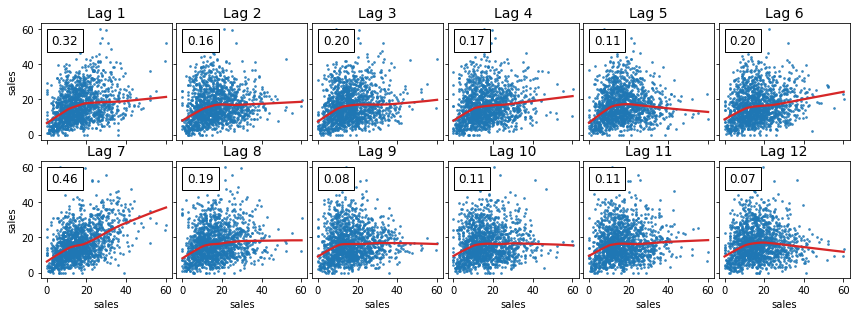

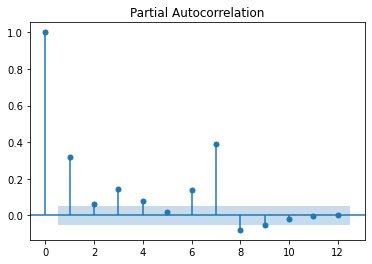

In [39]:
# Partial Autocorrelataion
from statsmodels.graphics.tsaplots import plot_pacf

plot_lags(ourtrain.sales, lags=12, nrows=2)
_ = plot_pacf(ourtrain.sales, lags=12)

In [40]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [107]:
from sklearn.model_selection import train_test_split

def cycle(ourtrain, ourtest):

    test_id = ourtest['id']

    # X_train = make_lags(ourtrain.sales, lags=7)
    # X_train = X_train.fillna(0.0)
    # y_train = ourtrain.sales

    # X_test = make_lags(ourtest.sales, lags=7)
    # X_test = X_test.fillna(0.0)




    X = make_lags(ourtrain.sales, lags=7)
    X = X.fillna(0.0)
    y = ourtrain.sales

    # Deleted 'Shuffle = "False"'
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(len(ourtest.index)))

    ts_model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
    ts_model.fit(X_train, y_train)
    y_fore = pd.Series(ts_model.predict(X_test), index=ourtest.index)
    

    y_fore = pd.concat([y_fore, test_id], axis=1)
    y_fore = y_fore.rename(columns={0: 'sales'})

    return y_fore

### 4) Hybrid

In [71]:
from xgboost import XGBRegressor

def hybrid(ourtrain, ourtest):

    test_id = ourtest['id']
 
    # Create features
    hybrid_dp = DeterministicProcess(
        index=ourtrain.index,  # dates from the training data
        constant=True,       # dummy feature for the bias (y_intercept)
        order=2,             # the time dummy (trend)
        drop=True,           # drop terms if necessary to avoid collinearity
    )

    # `in_sample` creates features for the dates given in the `index` argument
    X_train = hybrid_dp.in_sample()
    y_train = ourtrain['sales'] # Targets

    # Fit model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pre = pd.Series(model.predict(X_train), index=X_train.index)  # predicted value using in-sample(train)

    # Out of Sample 
    X_oos = hybrid_dp.out_of_sample(steps=len(ourtest.index))
    y_fore = pd.Series(model.predict(X_oos), index=X_oos.index)     # predicted value using out-sample(test)

    # Create residuals (the collection of detrended series) from the training set
    y_resid = y_train - y_pre

    # Train XGBoost on the residuals
    xgb = XGBRegressor()
    xgb.fit(X_train, y_resid)

    # Add the predicted residuals onto the predicted trends
    y_fore_boosted = xgb.predict(X_oos) + y_fore    # redisual(predicted) + linear forecasting
    y_fore_boosted = pd.concat([y_fore_boosted, test_id], axis=1)
    y_fore_boosted= y_fore_boosted.rename(columns={0: 'sales'})

    return y_fore_boosted


## 6. Proceed forecasting with the best model

In [116]:
# Find the best fit model
print("Total error with Trend model:", errors_model(trend))         # 1221.55
print("Total error with Seasonal model:", errors_model(seasonal))   # 1184.77
print("Total error with Cycle model:", errors_model(cycle))         # 969.21 -> 1961.25
print("Total error with Hybrid model:", errors_model(hybrid))       # 1522.74

Total error with Trend model: 1221.5500000000027
Total error with Seasonal model: 1184.7700000000004
Total error with Cycle model: 1963.5599999999995
Total error with Hybrid model: 1522.739999999996


In [131]:
forecasted = pd.DataFrame()
for store in store_list:
    for family in family_list:
        # modify train and test datasets
        train_m = date_features(store_family_subsets(train_subsets, store)[family])
        test_m = date_features(store_family_subsets(test_subsets, store)[family])

        # apply seasonal model
        y_fore = seasonal(train_m, test_m)

        forecasted = pd.concat([forecasted, y_fore])

# sort by 'id'
forecasted = forecasted.sort_values(by='id')    

# chage order of columns
cols = ['sales', 'id']
cols = cols[-1:] + cols[:-1]    # ['id', 'sales']
forecasted = forecasted[cols]

# round by 1
forecasted['sales'] = forecasted['sales'].apply(lambda x: round(x, 1))
forecasted

(28512, 2)


## 7. Create csv file

In [147]:
y_submit = forecasted.to_csv('submission.csv', index=False)